# 3D Convolutions : Understanding + Use Case - Drug Discovery
[3D Convolutions : Understanding + Use Case (kaggle_page)](https://www.kaggle.com/code/shivamb/3d-convolutions-understanding-use-case)
[3D-MNIST | basic CNN | Adorable visualisations](https://www.kaggle.com/code/michaelcripman/3d-mnist-basic-cnn-adorable-visualisations)
3D MNIST 데이터세트, 3D 컨볼루션과 구현을 설명한다.

### 컨볼루션
입력 데이터에서 저차원 특징을 추출한다. 또한 입력 데이터의 공간과 위치적 관계를 보존한다.

* 1D Convolutions   
window내의 로컬 패턴을 볼 수 있다.   
![](https://i.imgur.com/5UQz1zI.jpg)   

* 2D Convolutions   
![](https://tensorflowkorea.files.wordpress.com/2016/08/no_padding_no_strides1.gif)

* 3D Convolutions   
![](https://i.imgur.com/jriyCTU.png?1)   
![](https://i.imgur.com/YTYOdto.gif)

* Dilated Convolutions   
![](https://tensorflowkorea.files.wordpress.com/2016/08/padding_strides_transposed.gif)  
3*3 입력에 패딩과 사이 간격을 주어서 컨볼루션을 한 결과는 5*5 입력을 컨볼루션 한 결과와 동일한 크기를 만든다.   
![](https://tensorflowkorea.files.wordpress.com/2016/08/same_padding_no_strides.gif)   


In [1]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [132]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, Adadelta
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from keras.models import Model
import random
import numpy as np
import keras
import h5py

init_notebook_mode(connected=True)
%matplotlib inline

학습 데이터 10,000개 의 16,16,16 크기의 3d 숫자들이 있다.


In [73]:
with h5py.File("./data/train_point_clouds.h5", "r") as points_dataset:
    print(points_dataset['0']["img"])
    print(points_dataset['0']["points"])
    print(points_dataset['0'].attrs["label"])

<HDF5 dataset "img": shape (30, 30), type "<f8">
<HDF5 dataset "points": shape (25700, 3), type "<f8">
5


In [127]:
with h5py.File("./data/train_point_clouds.h5", "r") as points_dataset:        
    digits = []
    for i in range(10):
        digit = (points_dataset[str(i)]["img"][:], 
                 points_dataset[str(i)]["points"][:], 
                 points_dataset[str(i)].attrs["label"]) 
        digits.append(digit)
print(digits[0][1].shape)

n = 2
x_c = [r[0] for r in digits[n][1]]
print(len(x_c))
y_c = [r[1] for r in digits[n][1]]
z_c = [r[2] for r in digits[n][1]]

trace1 = go.Scatter3d(x=x_c, y=y_c, z=z_c, mode='markers', 
                      marker=dict(size=1, color=z_c, colorscale='Viridis', opacity=0.7))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Digit: "+str(digits[0][2]) + " in 3D space")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

(25700, 3)
21000


In [75]:
with h5py.File('./data/full_dataset_vectors.h5', 'r') as dataset:
    x_train = dataset["X_train"][:]
    x_test = dataset["X_test"][:]
    y_train = dataset["y_train"][:]
    y_test = dataset["y_test"][:]

print ("x_train shape: ", x_train.shape)
print ("y_train shape: ", y_train.shape)

print ("x_test shape:  ", x_test.shape)
print ("y_test shape:  ", y_test.shape)

x_train shape:  (10000, 4096)
y_train shape:  (10000,)
x_test shape:   (2000, 4096)
y_test shape:   (2000,)


16,16,16 크기의 데이터에 rgb 차원을 추가해 4차원의 16,16,16,3으로 변경한다.
라벨도 원핫 인코딩

In [76]:
xtrain = np.ndarray((x_train.shape[0], 4096, 3))
xtest = np.ndarray((x_test.shape[0], 4096, 3))

def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array

for i in range(x_train.shape[0]):
    xtrain[i] = add_rgb_dimention(x_train[i])
for i in range(x_test.shape[0]):
    xtest[i] = add_rgb_dimention(x_test[i])

xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

모델 구조 설계
입력 레이어 : 16,16,16,3
출력 레이어 : 

In [77]:
input_layer = Input((16, 16, 16, 3))

conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

model = Model(inputs=input_layer, outputs=output_layer)

모델 컴파일 후 훈련 시작

In [78]:
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(learning_rate=0.1), metrics=['acc'])
history = model.fit(x=xtrain, y=y_train, batch_size=128, epochs=100, validation_split=0.2)

Epoch 1/100
63/63 [==============================] - 10s 155ms/step - loss: 2.2651 - acc: 0.1831 - val_loss: 2.2944 - val_acc: 0.1480
Epoch 2/100
63/63 [==============================] - 10s 160ms/step - loss: 1.9432 - acc: 0.3322 - val_loss: 2.2362 - val_acc: 0.1885
Epoch 3/100
63/63 [==============================] - 11s 167ms/step - loss: 1.5543 - acc: 0.4734 - val_loss: 2.0546 - val_acc: 0.3505
Epoch 4/100
63/63 [==============================] - 10s 164ms/step - loss: 1.3044 - acc: 0.5634 - val_loss: 2.0897 - val_acc: 0.2915
Epoch 5/100
63/63 [==============================] - 10s 162ms/step - loss: 1.1514 - acc: 0.6101 - val_loss: 1.7279 - val_acc: 0.4895
Epoch 6/100
63/63 [==============================] - 10s 162ms/step - loss: 1.0571 - acc: 0.6381 - val_loss: 1.3532 - val_acc: 0.5870
Epoch 7/100
63/63 [==============================] - 10s 162ms/step - loss: 0.9875 - acc: 0.6612 - val_loss: 1.4208 - val_acc: 0.5425
Epoch 8/100
63/63 [==============================] - 10s 162ms

In [79]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
accuracy = sum(pred==np.argmax(y_test, axis=1))/len(pred)
print(int(accuracy*len(pred)),"/",len(pred))
print(accuracy)


63/63 [==============================] - 1s 8ms/step
1281 / 2000
0.6405


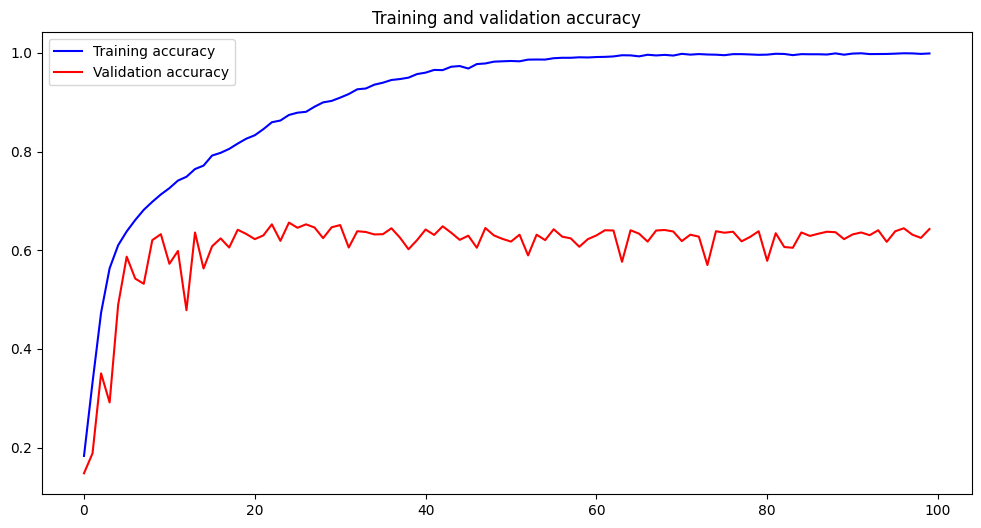

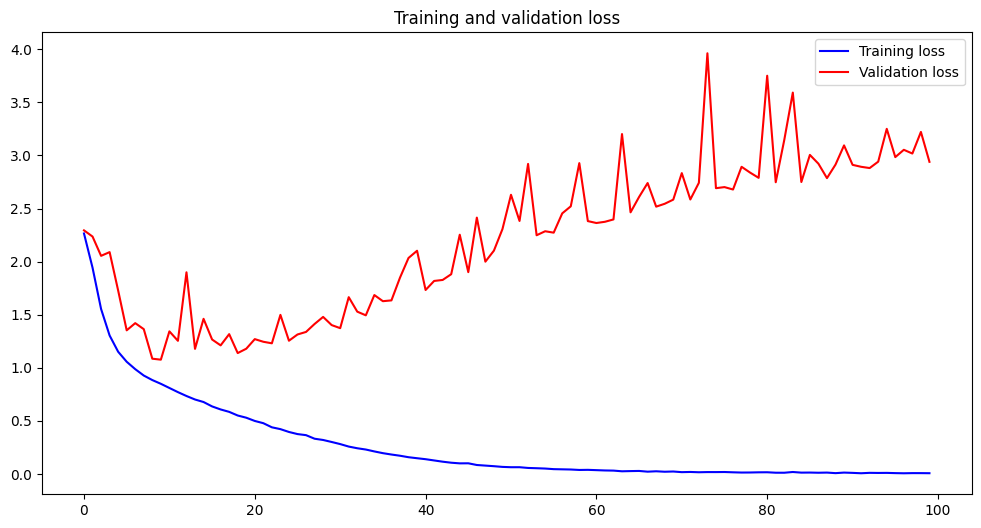

In [80]:
plt.figure(figsize = (12, 6))
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label = "Training accuracy")
plt.plot(epochs, val_accuracy, 'r', label = "Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure(figsize = (12, 6))
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [162]:
miss = np.where(pred != np.argmax(y_test, axis=1))[0]
miss

array([   3,    9,   13,   15,   17,   19,   23,   25,   31,   33,   36,
         37,   39,   41,   45,   47,   49,   51,   55,   60,   61,   66,
         71,   87,   91,   99,  102,  103,  107,  109,  117,  119,  121,
        123,  124,  125,  126,  127,  129,  131,  135,  137,  141,  145,
        146,  147,  151,  155,  159,  160,  163,  165,  167,  169,  171,
        174,  175,  183,  185,  187,  188,  191,  194,  195,  197,  199,
        207,  209,  211,  217,  221,  223,  225,  227,  229,  231,  235,
        237,  239,  241,  242,  247,  250,  251,  255,  259,  267,  277,
        279,  281,  283,  285,  287,  289,  295,  299,  301,  302,  303,
        305,  307,  311,  313,  316,  317,  319,  321,  325,  327,  329,
        331,  333,  335,  337,  339,  341,  343,  345,  346,  347,  349,
        355,  361,  363,  365,  368,  371,  373,  375,  385,  387,  390,
        391,  395,  397,  399,  403,  411,  413,  415,  419,  421,  425,
        427,  429,  433,  434,  435,  437,  439,  4

In [161]:
plot_idx = miss[0]
plot_img_3d = np.squeeze(xtest[plot_idx])
print(plot_img_3d.shape)
plot_label = np.argmax(y_test, axis=1)[plot_idx]

plot_data = []
for x in range(0,16):
    for y in range(0,16):
        for z in range(0,16):
            val = plot_img_3d[x, y, z]
            if val[0]==1:
                continue
            plot_data.append([x,y,z,val])

plot_df = pd.DataFrame(plot_data, columns=["x", "y", "z", "val"])
# plot_df = plot_df.loc[plot_df["val"][0] > 0 and plot_df["val"][0] > 0 and plot_df["val"][0] > 0]

trace1 = go.Scatter3d(x=plot_df['x'], y=plot_df['y'], z=plot_df['z'], mode='markers', 
                      marker=dict(size=3, color=[f'rgb({c[0]}, {c[1]}, {c[2]})' for c in plot_df['val']], colorscale='Viridis', opacity=0.7))

data = [trace1]
layout = go.Layout(height=500, width=600, title= "Digit: "+str(digits[0][2]) + " in 3D space")
fig = go.Figure(data=data, layout=layout)
iplot(fig)

(16, 16, 16, 3)
